In [7]:
import itertools
import pathlib
from typing import List

import msgspec
from yoshimidi.data.parse.tracks import Track

input_file = pathlib.Path("../out/dataset/dataset_parsed.jsonl").resolve()

In [9]:
rows = []
with input_file.open("r") as f:
    for line in itertools.islice(f, 100):
        tracks = msgspec.json.decode(line, type=List[Track])
        for track in tracks:
            for channel in track.channels.values():
                for note in channel.notes:
                    rows.append(note.time_delta_secs)

316.875
0.0
[4.88281250e-04 2.68817083e-03 4.16666667e-03 6.72042708e-03
 9.40859792e-03 1.35416667e-02 1.82291667e-02 2.50000000e-02
 3.33333333e-02 5.00000000e-02 6.25000000e-02 8.54166667e-02
 1.06770833e-01 1.25000000e-01 1.42708333e-01 1.89655125e-01
 2.37500000e-01 2.50000000e-01 4.00000000e-01 6.25000000e-01
 3.16875000e+02]


/Users/misha/src/yoshimidi/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'pd' is not defined

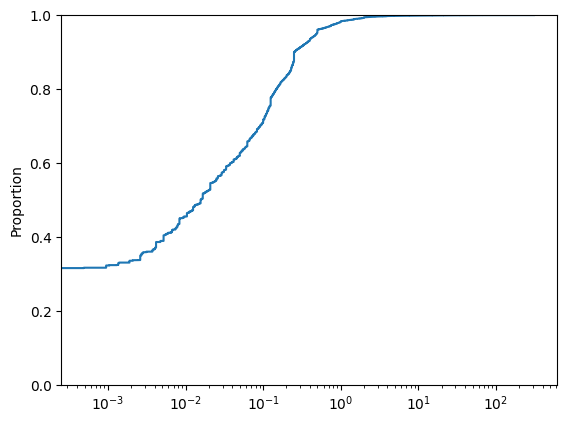

In [50]:
import pandas as pd
import seaborn as sns
import numpy as np

rows = np.array(rows)
sns.ecdfplot(rows, log_scale=True)
print(rows.max())
print(((0 < rows) & (rows < 1e-4)).mean())
print(np.quantile(rows[rows > 0], np.arange(0, 1.0001, 0.05)))

buckets = [0, *[2**exponent for exponent in range(-8, 1)], 300]
df = []
for idx in range(len(buckets)):
    bucket_rows = rows
    lower_thresh = None
    upper_thresh = None
    if idx > 0:
        lower_thresh = (buckets[idx - 1] + buckets[idx]) / 2
        bucket_rows = bucket_rows[lower_thresh <= bucket_rows]
    if idx < len(buckets) - 1:
        upper_thresh = (buckets[idx] + buckets[idx + 1]) / 2
        bucket_rows = bucket_rows[bucket_rows < upper_thresh]
    df.append(
        dict(
            bucket=buckets[idx],
            lower_thresh=lower_thresh,
            upper_thresh=upper_thresh,
            perc=len(bucket_rows) / len(rows),
        )
    )

print(pd.DataFrame(df))
